In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim

import os
import shutil

In [18]:
# define hyperparameters
N_EPOCHS = 2
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_TEST = 1000
LEARNING_RATE = 0.1

In [19]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = functional.relu(functional.max_pool2d(self.conv1(x), 2))
        x = functional.relu(functional.max_pool2d(
            self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = functional.relu(self.fc1(x))
        x = functional.dropout(x, training=self.training)
        x = self.fc2(x)
        return functional.log_softmax(x)

In [20]:
def get_data():
    # get data with torchvision
    train_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data/', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307,), (0.3081,))
                                   ])),
        batch_size=BATCH_SIZE_TRAINING, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST('./data/', train=False, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307,), (0.3081,))
                                   ])),
        batch_size=BATCH_SIZE_TEST, shuffle=True)

    return train_loader, test_loader

In [21]:
def train(epoch, network, optimizer, loader, losses, counter):
    network.train()
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = network(data)
        loss = functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'
                  .format(
                      epoch, batch_idx * len(data),
                      len(loader.dataset),
                      100. * batch_idx / len(loader),
                      loss.item()
                  )
                  )
            losses.append(loss.item())
            counter.append(
                (batch_idx*64) + ((epoch-1)*len(loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

def test(network, loader, losses, counter):
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = network(data)
            test_loss += functional.nll_loss(output,
                                             target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(loader.dataset)
    losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))

In [22]:
def visualize(train_counter, train_losses, test_counter, test_losses):
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    fig

In [23]:
def main():
    train_loader, test_loader = get_data()
    network = MyNet()
    optimizer = optim.SGD(network.parameters(),
                          lr=LEARNING_RATE)

    # remove gradients for saving memory
    optimizer.zero_grad()
    try:
        os.mkdir("results")
    except FileExistsError as err:
        shutil.rmtree("results")
        os.mkdir("results")

    train_losses = []
    train_counter = []

    test_losses = []
    test_counter = [i*len(train_loader.dataset) for i in range(N_EPOCHS + 1)]

    test(network, test_loader, test_losses, test_counter)
    for ep in range(1, N_EPOCHS + 1):
        train(ep, network, optimizer, train_loader, train_losses, train_counter)
        test(network, test_loader, test_losses, test_counter)

    visualize(train_counter, train_losses, test_counter, test_losses)

C:\Users\Anton\AppData\Local\Temp/ipykernel_3156/4103797466.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return functional.log_softmax(x)



Test set: Avg. loss: 2.2998, Accuracy: 1031/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.298460
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.716664
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.632510
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.462122
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.377523
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.341376

Test set: Avg. loss: 0.1009, Accuracy: 9679/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.243433
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.402981
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.248848
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.300803
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.206807
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.268073

Test set: Avg. loss: 0.0809, Accuracy: 9749/10000 (97%)



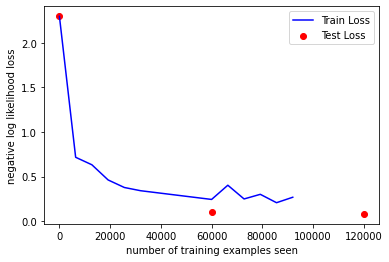

In [24]:
main()